In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from descriptor_calculator import * # Module for molecular fingerprint & descriptor calculations
from training import * # Module for model training and cross validation
from hyperopt import opt_hyper_param # Module for hyperparameter optimization

## Load data 

In [2]:
# Load and clean raw data
df_raw = pd.read_csv('./data/data.csv')
df = df_raw[df_raw['Max_LCAP'].notna()]
df = df.reset_index()
df = df.drop(columns=['index'])
df['Round_Number'] = df['Round_Number'].apply(lambda x: int(str(x)[-1]))
df.head()

,ID_Number,Canonical_Smiles,Round_Number,Max_LCAP
0,4897720,CCCCn1ccnc1,0,0
1,18461035,CC(=O)c1ocnc1,0,72
2,1762470,Fc1ccc(cc1)c2ocnc2,0,87
3,16916940,Brc1ccc(cc1)c2cncs2,0,78
4,1040111,Fc1cc(ccc1[C@@H]2CCc3cncn23)C#N,0,0


In [3]:
# Load and clean raw data
df_raw = pd.read_csv('./data/data.csv')

# Filter out rows without Max_LCAP values
df = df_raw[df_raw['Max_LCAP'].notna()]
df = df.reset_index(drop=True)

# Extract the last digit from Round_Number and convert it to an integer
df['Round_Number'] = df['Round_Number'].apply(lambda x: int(str(x)[-1]))
df.head()

,ID_Number,Canonical_Smiles,Round_Number,Max_LCAP
0,4897720,CCCCn1ccnc1,0,0
1,18461035,CC(=O)c1ocnc1,0,72
2,1762470,Fc1ccc(cc1)c2ocnc2,0,87
3,16916940,Brc1ccc(cc1)c2cncs2,0,78
4,1040111,Fc1cc(ccc1[C@@H]2CCc3cncn23)C#N,0,0


In [4]:
# Load descriptors calculated using internal platform
mix_desc_df = pd.read_csv('./data/mix_des.csv')
mix_desc_df = mix_desc_df.dropna(axis=1)

# Extract feature names, excluding the first column (presumably an identifier)
mix_features = mix_desc_df.columns.tolist()[1:]
print(f'There are {len(mix_features)} imported MIX features from internal platform.')

# Merge the mix descriptors with the main DataFrame on 'ID_Number'
df = df.merge(mix_desc_df, on='ID_Number')
df.head()

There are 3747 imported MIX features from internal platform.


,ID_Number,Canonical_Smiles,Round_Number,Max_LCAP,BrX1sp3BrX1sp305,CX1sp3BrX1sp303,CX1sp3BrX1sp304,CX1sp3BrX1sp305,CX1sp3BrX1sp306,CX1sp3BrX1sp307,...,X4sp3ClX1sp311,X4sp3NX2sp205,X4sp3NX2sp206,X4sp3NX2sp207,X4sp3NX2sp209,X4sp3NX2sp211,X4sp3NX3sp305,X4sp3OX1sp211,X4sp3OX2sp303,X4sp3SX2sp304
0,4897720,CCCCn1ccnc1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,18461035,CC(=O)c1ocnc1,0,72,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1762470,Fc1ccc(cc1)c2ocnc2,0,87,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16916940,Brc1ccc(cc1)c2cncs2,0,78,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1040111,Fc1cc(ccc1[C@@H]2CCc3cncn23)C#N,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Load descriptors calculated from DFT-optimized geometries
df_dft = pd.read_csv('./data/data_dft.csv')

# Define DFT features
dft_features = [
    'N (eV)', 'HOMO (eV)', 'LUMO (eV)', 'Gap (eV)', 
    'Omega', 'dqG', 'Bmin', 'Bmax', 
    'L', 'PMI_X', 'PMI_Y', 'PMI_Z'
]

print(f'There are {len(dft_features)} imported DFT features.')

There are 12 imported DFT features.


In [6]:
# Calculate molecular fingerprints and descriptors
rdkit_desc = calc_rdkit_desc(df)  # Compute RDKit descriptors
rdkit_fp = calc_rdkit_fp(df, radius=2, nBits=2048)  # Compute molecular fingerprints

# Combine descriptors and fingerprints into a single DataFrame
desc_fp = rdkit_desc.join(rdkit_fp)

# Optionally save combined dataframe of descriptors and fingerprints to a CSV file
#desc_fp.to_csv('./data/rdkit_desc_fp.csv', index=False)

rdkit_features = desc_fp.columns.tolist()

In [7]:
# Combine all features into a single dataframe
df_clean = pd.concat(
    [
        df[['Canonical_Smiles', 'Round_Number', 'Max_LCAP', 'ID_Number'] + mix_features], 
        desc_fp
    ], 
    axis=1
)

# Merge on 'SMILES' to include DFT features
df_clean = df_clean.merge(df_dft[dft_features + ['Canonical_Smiles']], on='Canonical_Smiles')

# Optionally save all features to a CSV file
#df_clean.to_csv('all_features.csv', index=False)

df_clean.head()

,Canonical_Smiles,Round_Number,Max_LCAP,ID_Number,BrX1sp3BrX1sp305,CX1sp3BrX1sp303,CX1sp3BrX1sp304,CX1sp3BrX1sp305,CX1sp3BrX1sp306,CX1sp3BrX1sp307,...,LUMO (eV),Gap (eV),Omega,dqG,Bmin,Bmax,L,PMI_X,PMI_Y,PMI_Z
0,CCCCn1ccnc1,0,0,4897720,0,0,0,0,0,0,...,1.55,9.23,0.018667,66.200171,1.71,7.91,5.10,15.11284,119.05900,132.05374
1,CC(=O)c1ocnc1,0,72,18461035,0,0,0,0,0,0,...,-0.79,7.93,0.052357,52.809485,1.74,4.66,7.15,17.18341,52.33765,69.00428
2,Fc1ccc(cc1)c2ocnc2,0,87,1762470,0,0,0,0,0,0,...,-0.34,7.07,0.039040,56.561304,1.65,6.65,8.40,23.60169,178.26557,201.86727
3,Brc1ccc(cc1)c2cncs2,0,78,16916940,0,0,0,0,0,0,...,-0.88,6.60,0.048713,55.462471,1.71,5.40,10.80,29.47762,386.11696,415.59459
4,Fc1cc(ccc1[C@@H]2CCc3cncn23)C#N,0,0,1040111,0,0,0,0,0,0,...,-0.95,6.63,0.050420,63.966738,1.78,7.98,5.95,87.74469,306.39359,323.60486


## Data validation 

In [8]:
# y-scramble/y-randomization validation

# Calculate performance for Round 7 model
performance = cv_random_split_metrics(
    model='random forest', 
    data=df_clean[df_clean.Round_Number <= 7], 
    descriptors=mix_features, 
    nsplits=20, 
    metric_method='average performance'
)

# Create a scrambled version of the DataFrame
df_scramble = df_clean.copy()
df_scramble['Max_LCAP'] = df_scramble['Max_LCAP'].sample(frac=1).reset_index(drop=True)

# Calculate performance with y-scramble
performance_scrambled = cv_random_split_metrics(
    model='random forest', 
    data=df_scramble, 
    descriptors=mix_features, 
    nsplits=20, 
    metric_method='average performance'
)

df = pd.DataFrame.from_dict(performance_scrambled, orient='index', columns=['y-scramble'])
df_2 = pd.DataFrame.from_dict(performance, orient='index', columns=['no y-scramble'])
df = pd.concat([df, df_2], axis=1)
#df.to_csv('./data/y_scramble_results.csv')
df.head()

Total run time is 315.55 seconds
Total run time is 503.22 seconds


,y-scramble,no y-scramble
pearson r2,0.019303,0.764595
mae,25.944050,8.309387
r2 score,-0.140989,0.753696
rmse,33.347540,15.637325


## Tune hyperparameters 

### Split method: 80:20 train:test random split

#### Train a RF model using 80% of randomly split data with default hyperparameters and predict on remaining 20% test set.

Total run time is 15.31 seconds
       Metric      Value
0  pearson r2   0.864244
1         mae   7.442821
2    r2 score   0.862328
3        rmse  12.015783


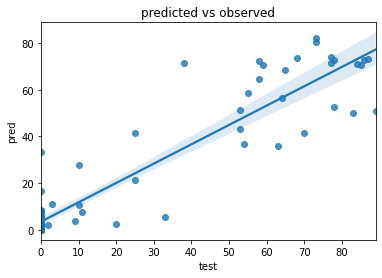

In [9]:
# Train RF model with default hyperparameters using randomly split 80% of data 
rf = RandomForestRegressor()
trained_rf, performance, preds = model_training(
    data=df_clean, 
    descriptors=mix_features, 
    model=rf, 
    split_method='random'
)

# View performance of model on randomly split 20% test set
performance_df = pd.DataFrame(performance.items(), columns=['Metric', 'Value'])
print(performance_df)

# Plot predicted vs observed
pred_df = pd.DataFrame(preds)
sns.regplot(data=pred_df, x='test', y='pred')
plt.title('predicted vs observed')
plt.show()

#### Compare with RF model with tuned hyperparameters using 80% randomly split data and predict on remaining 20% test set.

Total run time is 16.05 seconds
       Metric      Value
0  pearson r2   0.621337
1         mae  11.423511
2    r2 score   0.602918
3        rmse  20.724065


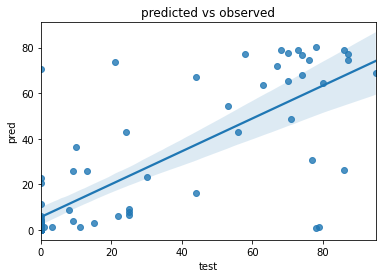

In [10]:
# Tune hyperparameters using randomly split 80% of data
descs = mix_features
best_rf, df_train, df_test = opt_hyper_param(data=df_clean, descriptors=descs)

# Make predictions on reserved randomly split 20% of data using model trained with tuned hyperparameters
trained_rf, performance, preds = model_training(
    data=df_train, 
    model=best_rf, 
    descriptors=descs, 
    test_df=df_test
)

# View performance of model on randomly split test set
performance_df = pd.DataFrame(performance.items(), columns=['Metric', 'Value'])
print(performance_df)

# Plot predicted vs. observed
pred_df = pd.DataFrame(preds)
sns.regplot(data=pred_df, x='test', y='pred')
plt.title('predicted vs observed')
plt.show()  # Include this line to display the plot

### Split method: rounds 0-6:round7 train:test split

#### #### Train a RF model using rounds 0-6 data with default hyperparameters and predict on round 7.

Total run time is 4.23 seconds
       Metric      Value
0  pearson r2   0.899271
1         mae  10.983636
2    r2 score   0.846274
3        rmse  13.218156


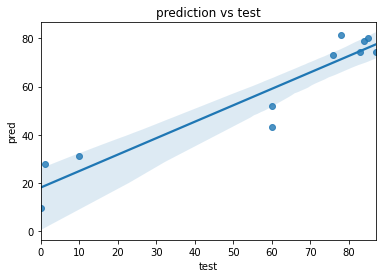

In [11]:
# Train RF model with default hyperparameters using rounds 0-6 data
rf = RandomForestRegressor()
trained_rf, performance, preds = model_training(
    data=df_clean, 
    descriptors=mix_features, 
    model=rf, 
    split_method='round'
)

# View performance of model on round 7
performance_df = pd.DataFrame(performance.items(), columns=['Metric', 'Value'])
print(performance_df)

# Plot predicted vs observed
pred_df = pd.DataFrame(preds)
sns.regplot(data=pred_df, x='test', y='pred')
plt.title('prediction vs test')
plt.show() 

#### Compare with RF model with tuned hyperparameters using rounds 0-6 data and predict on round 7.

Total run time is 56.48 seconds
       Metric      Value
0  pearson r2   0.920040
1         mae  15.031719
2    r2 score   0.772039
3        rmse  16.096333


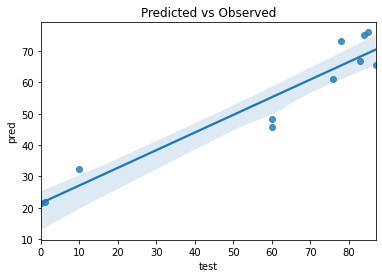

In [12]:
# Tune hyperparameters using Round 6 model
descs = df_clean.columns.tolist()[4:]  # Extract descriptors starting from the 5th column
best_rf, df_train, df_test = opt_hyper_param(
    data=df_clean, 
    descriptors=descs, 
    split_method='round'
)

# Make predictions on reserved Round 7 compounds using model trained with tuned parameters
trained_rf, performance, preds = model_training(
    data=df_train, 
    descriptors=descs, 
    model=best_rf, 
    test_df=df_test
)

# View performance of model on Round 7 compounds
performance_df = pd.DataFrame(performance.items(), columns=['Metric', 'Value'])
print(performance_df)

# Plot prediction vs experimental results
pred_df = pd.DataFrame(preds)
sns.regplot(data=pred_df, x='test', y='pred')
plt.title('Predicted vs Observed')
plt.show() 

## DFT feature performance for predicting Round 6 compounds from Round 5 model

Total run time is 0.89 seconds


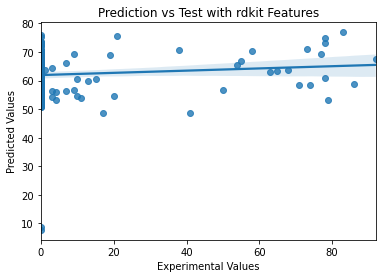

Total run time is 0.15 seconds


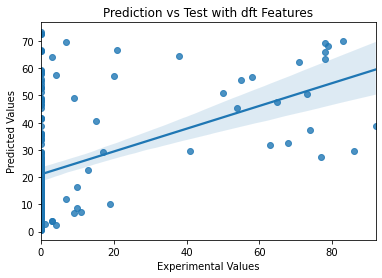

Total run time is 1.13 seconds


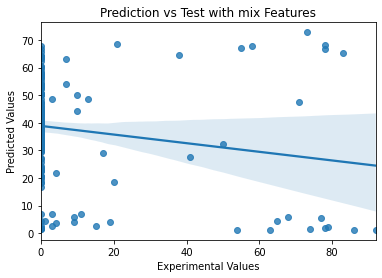

Total run time is 0.90 seconds


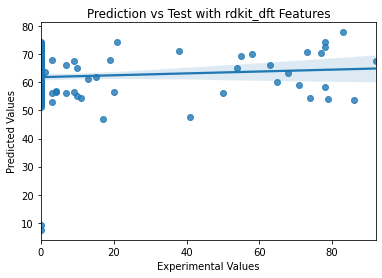

           pearson r2        mae  r2 score       rmse
rdkit        0.009502  56.443981 -7.496652  58.905959
dft          0.181466  20.671991 -0.824975  27.300071
mix          0.035122  38.395741 -3.296983  41.890653
rdkit_dft    0.007200  56.466944 -7.479006  58.844756


In [13]:
# Train Round 5 model, predict on Round 6 compounds using different features
# Split by round
round6_performance = {}

# Define features for different models
feature_dict = {
    'rdkit': rdkit_features,
    'dft': dft_features,
    'mix': mix_features,
    'rdkit_dft': dft_features + rdkit_features
}

# Loop through different feature sets
for feature_set_name, features in feature_dict.items():
    # Initialize Random Forest Regressor
    rf = RandomForestRegressor(random_state=0)
    
    # Prepare data for training
    data_for_training = df_clean[df_clean.Round_Number <= 6]
    
    # Train the model and get performance metrics
    _, performance, preds = model_training(
        data=data_for_training,
        model=rf,
        split_method='round',
        descriptors=features
    )
    
    # Store performance metrics in a dictionary
    round6_performance[feature_set_name] = performance
    
    # Prepare predictions for visualization
    pred_df = pd.DataFrame(preds)
    
    # Optionally save predictions for DFT features to CSV
    #if feature_set_name == 'dft':
    #    pred_df.to_csv('./data/dft_preds_round5_on_round6.csv', index=False)
    
    # Create a scatter plot to visualize predictions vs experimental results
    plt.figure()
    sns.regplot(data=pred_df, x='test', y='pred')
    plt.title(f'Prediction vs Test with {feature_set_name} Features')
    plt.xlabel('Experimental Values')
    plt.ylabel('Predicted Values')
    plt.show()  # Show the plot

# Create a DataFrame to display performance metrics
performance_df = pd.DataFrame.from_dict(round6_performance, orient='index')  # Create DataFrame from dict

# Display performance metrics
print(performance_df)

In [14]:
# Calculate permutation feature importance for RF DFT model
rf = RandomForestRegressor(random_state=0)

# Train Round 5 model using DFT features and predict on Round 6 compounds
trained_rf, performance, preds = model_training(
    data=df_clean[df_clean.Round_Number <= 6],
    model=rf,
    split_method='round',
    descriptors=feature_dict['dft']
)

# Extract feature importances
importances = trained_rf.feature_importances_
std_dev = np.std([tree.feature_importances_ for tree in trained_rf.estimators_], axis=0)

# Prepare feature names and calculate PFI
feature_names = dft_features
forest_importances = pd.Series(importances, index=feature_names)

# Sort features by importance
feature_list_ordered = forest_importances.sort_values(ascending=False)
feature_importance_df = pd.DataFrame({
    'Feature': feature_list_ordered.index,
    'PFI': feature_list_ordered.values
})

print(feature_importance_df)

Total run time is 0.15 seconds
      Feature       PFI
0       PMI_X  0.180250
1        Bmax  0.170323
2         dqG  0.151675
3           L  0.128990
4       PMI_Z  0.093402
5        Bmin  0.079007
6       PMI_Y  0.051001
7    Gap (eV)  0.050269
8   HOMO (eV)  0.026333
9       Omega  0.026071
10  LUMO (eV)  0.021797
11     N (eV)  0.020880


## Model evolution: train Round 0 to 7 models and plot performances 

In [15]:
# Train default RF models for Rounds 0 to 7 using MIX descriptors
rf = RandomForestRegressor()
r2s = []
maes = []
numbers = []
rounds = range(8)  # Using range for cleaner iteration

for r in tqdm(rounds):
    # Calculate performance metrics with a random split
    performance = cv_random_split_metrics(data=df_clean[df_clean.Round_Number <= r], descriptors=mix_features) 
    
    # Append performance metrics and number of samples for current round
    r2s.append(performance['pearson r2'])
    numbers.append(len(df_clean[df_clean.Round_Number <= r]))
    maes.append(performance['mae'])
    
results = pd.DataFrame({
    'Round Number': rounds,
    'Number of Compounds': numbers,
    'R2': r2s,
    'MAE': maes
})

# Optionally save results to a CSV file
#results.to_csv('./data/performance_vs_datasize.csv', index=False)

 12%|█▎        | 1/8 [00:04<00:30,  4.29s/it]

Total run time is 4.29 seconds


 25%|██▌       | 2/8 [00:13<00:42,  7.15s/it]

Total run time is 9.14 seconds


 38%|███▊      | 3/8 [00:23<00:41,  8.28s/it]

Total run time is 9.61 seconds


 50%|█████     | 4/8 [00:33<00:36,  9.08s/it]

Total run time is 10.30 seconds


 62%|██████▎   | 5/8 [00:44<00:29,  9.97s/it]

Total run time is 11.55 seconds


 75%|███████▌  | 6/8 [01:02<00:25, 12.53s/it]

Total run time is 17.47 seconds


 88%|████████▊ | 7/8 [02:01<00:27, 27.68s/it]

Total run time is 58.84 seconds


100%|██████████| 8/8 [03:06<00:00, 23.29s/it]

Total run time is 65.00 seconds


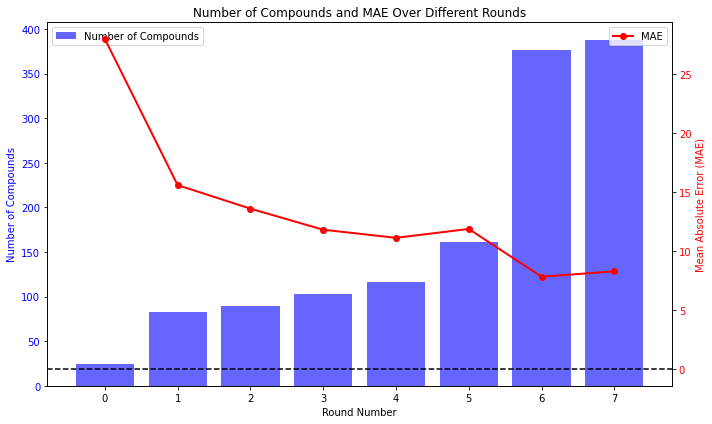

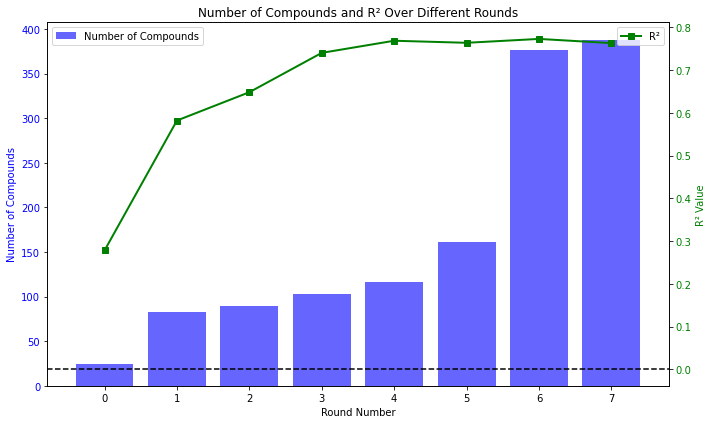

In [16]:
# Plot to compare predictions versus experimental results
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(rounds, numbers, color='b', alpha=0.6, label='Number of Compounds')
ax1.set_xlabel('Round Number')
ax1.set_ylabel('Number of Compounds', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(rounds, maes, color='r', marker='o', label='MAE', linewidth=2)
ax2.set_ylabel('Mean Absolute Error (MAE)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax2.axhline(0, color="k", linestyle="--") # Reference line for MAE
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Number of Compounds and MAE Over Different Rounds')
plt.tight_layout()
#plt.savefig('./data/number_of_compounds_mae.png', dpi=300)
plt.show()


fig, ax3 = plt.subplots(figsize=(10, 6))

ax3.bar(rounds, numbers, color='b', alpha=0.6, label='Number of Compounds')
ax3.set_xlabel('Round Number')
ax3.set_ylabel('Number of Compounds', color='b')
ax3.tick_params(axis='y', labelcolor='b')
ax4 = ax3.twinx()
ax4.plot(rounds, r2s, color='g', marker='s', label='R²', linewidth=2)
ax4.set_ylabel('R² Value', color='g')
ax4.tick_params(axis='y', labelcolor='g')
ax4.axhline(0, color="k", linestyle="--") # Reference line for R²

ax3.legend(loc='upper left')
ax4.legend(loc='upper right')
plt.title('Number of Compounds and R² Over Different Rounds')
plt.tight_layout()
#plt.savefig('./data/number_of_compounds_r2.png', dpi=300)
plt.show()